# <center> Deep Learning Project:

> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 

- The project is organized as follows:

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
#!pip install findspark
#!pip install tensorflow-addons

In [2]:
import time
t1 = time.perf_counter()

- __Importing the necessary libraries 📚:__

In [3]:
import os
from zipfile import ZipFile
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import tensorflow_addons as tfa

In [4]:
from keras.models import Model, Sequential
from keras import layers
#from keras.layers import Dense, BatchNormalization, LSTM, Embedding, Input, Dropout, SimpleRNN, RNN, Bidirectional
#from keras.Optimizer import Adam, SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl, schedules
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, History, ReduceLROnPlateau 
#from keras.utils import plot_model
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
import keras.backend as K

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import class_weight

from pprint import pprint
import IPython

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import category_encoders as ce
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
import keras_tuner as kt

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
SEED = 2022

LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 10
time_steps=5

Fixing the random number seed to ensure our results are reproducible.

In [41]:
session = K.get_session()
# init_op = tf.group(tf.tables_initializer(),tf.global_variables_initializer(),
# tf.local_variables_initializer())
#session.run(init_op)

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [42]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='binary'),
                metricsObj.f1_score(yTrain, yPredTrain, average='binary'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='binary'),
               metricsObj.f1_score(yTest, yPredTest, average='binary'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
    return(resultsDF)

In [43]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [44]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [45]:
def create_model(nl=1, nn=256):
    model = Sequential()
    model.add(Dense(16, input_shape=(2,), activation="relu"))
    # Add as many hidden layers as specified in nl
    for i in range(nl):
        # Layers have nn neurons
        model.add(Dense(nn, activation='relu'))
    # End defining and compiling your model...

In [46]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.show()

In [47]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()


In [48]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_loss(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [49]:
# This function plot the "accuracy" and the "val_accuracy" variables.
def visualize_accuracy(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
# This function plot the "error" and the "val_error" variables.
def visualize_error(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    error = history.history["mae"]
    val_error = history.history["val_mae"]
    epochs = range(len(error))
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, error, "b", label="Training error")
    plt.plot(epochs, val_error, "r", label="Validation error")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
def show_plot(plot_data, delta, title):
    """
    plot_data:
    delta:
    title:
    """
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.tight_layout()
    plt.show()
    return

In [51]:
def plot_predictions(val, predicted, title, date):
    plt.figure(figsize=(16,4))
    plt.plot(date, val, color='blue',label='Actual') # date, 
    plt.plot(date,predicted, alpha=0.7, color='red',label='Predict') # date, 
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Something')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [37]:
# def focal_loss(gamma=2., alpha=4.):

#     gamma = float(gamma)
#     alpha = float(alpha)

#     def focal_loss_fixed(y_true, y_pred):
#         """Focal loss for multi-classification
#         FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
#         Notice: y_pred is probability after softmax
#         gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
#         d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
#         Focal Loss for Dense Object Detection
#         https://arxiv.org/abs/1708.02002

#         Arguments:
#             y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
#             y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

#         Keyword Arguments:
#             gamma {float} -- (default: {2.0})
#             alpha {float} -- (default: {4.0})

#         Returns:
#             [tensor] -- loss.
#         """
#         epsilon = 1.e-9
#         y_true = tf.convert_to_tensor(y_true, tf.float32)
#         y_pred = tf.convert_to_tensor(y_pred, tf.float32)

#         model_out = tf.add(y_pred, epsilon)
#         ce = tf.multiply(y_true, -tf.math.log(model_out))
#         weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
#         fl = tf.multiply(alpha, tf.multiply(weight, ce))
#         reduced_fl = tf.reduce_max(fl, axis=1)
#         return tf.reduce_mean(reduced_fl)
#     return focal_loss_fixed

- __Loading the dataset:__

In [52]:
ds= pd.read_csv("bankruptcy.csv")

In [53]:
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [54]:
# Checking the shape of the dataset:
ds.shape

(6819, 96)

In [55]:
# This is the target variable.
ds["Bankrupt?"].unique()

array([1, 0])

## Data Preprocessing

### Data Type
All the columns are numeric. There are 2 binary flags that are already enocoded as 0 or 1.
- 85: Liability-Assets Flag
- 94: Net Income Flag

In [156]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1    ROA(A) before interest and % after tax                   6819 non-null   float64
 2    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 3    Continuous interest rate (after tax)                     6819 non-null   float64
 4    Net Value Per Share (B)                                  6819 non-null   float64
 5    Persistent EPS in the Last Four Seasons                  6819 non-null   float64
 6    Per Share Net profit before tax (Yuan ¥)                 6819 non-null   float64
 7    Interest Expense Ratio                                   6819 non-null   float64
 8    Total debt/Total 

### Check For Duplicates

In [157]:
ds.duplicated().sum()

0

### Correlation

In [158]:
corr = ds.corr()
i = 1
for (index, row) in corr.iterrows():
    for col in corr.columns[i:]:
        if row[col] > 0.9:
            print(f"{index} vs. {col} are highly correlated {row[col]}")
    i += 1
    
# Select upper triangle of correlation matrix
corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.9
correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > 0.9)]
# Drop correlated columns
ds = ds.drop(correlated_cols, axis=1)

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9401237079700807
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9868494970182541
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9557406252835042
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9615519166312979
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.9120401733352151
 Persistent EPS in the Last Four Seasons vs.  Per Share Net profit before tax (Yuan ¥) are highly correlated 0.9555910456161516
 Persistent EPS in the Last Four Seasons vs.  Net profit before tax/Paid-in capital are highly correlated 0.9594608424800604
 Per Share Net profit before tax (Yuan ¥) vs.  Net profit before tax/Paid-in ca

## Feature Selection

In [64]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y)).sort_values(ascending=False)
    mi.index = X.columns
    mi.plot.bar(figsize=(20, 6))
    plt.ylabel('Mutual Information Score')
    return mi

 Cash Flow to Liability                                0.001447
 CFO to Assets                                         0.001427
 Cash Flow to Equity                                   0.001404
 Current Liability to Current Assets                   0.001379
 Liability-Assets Flag                                 0.001328
 Net Income to Total Assets                            0.000437
 Total assets to GNP price                             0.000340
 No-credit Interval                                    0.000000
 Gross Profit to Sales                                 0.000000
 Net Income to Stockholder's Equity                    0.000000
 Liability to Equity                                   0.000000
 Degree of Financial Leverage (DFL)                    0.000000
 Interest Coverage Ratio (Interest expense to EBIT)    0.000000
 Net Income Flag                                       0.000000
 Equity to Liability                                   0.000000
dtype: float64

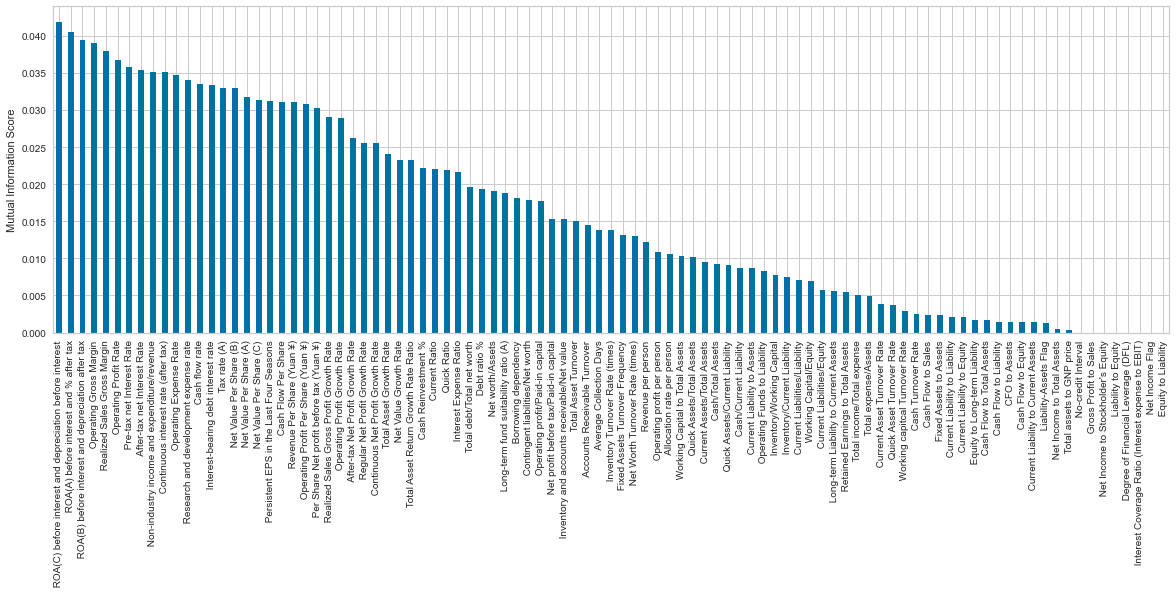

In [65]:
fs_scores = MutualInfoScores(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])
fs_scores.tail(15)

In [66]:
zero_score_cols = fs_scores.loc[fs_scores == 0].index
X = ds.drop(columns=zero_score_cols)
X.shape

(6819, 88)

In [67]:
selector = SelectKBest(mutual_info_classif, k=20)

# selecting the features:
selector.fit(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])

kept_columns = list(ds.drop(columns="Bankrupt?").columns[selector.get_support()]) + ["Bankrupt?"]

In [68]:
ds = ds[kept_columns]

In [69]:
ds.shape

(6819, 21)

In [70]:
ds.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Continuous interest rate (after tax),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,...,Borrowing dependency,Net profit before tax/Paid-in capital,Retained Earnings to Total Assets,Net Income to Total Assets,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.780985,0.147950,0.169141,0.138736,0.629951,0.021266,0.207576,...,0.390284,0.137757,0.903225,0.716845,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.781506,0.182251,0.208944,0.169918,0.635172,0.012502,0.171176,...,0.376760,0.168962,0.931065,0.795297,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.780284,0.177911,0.180581,0.142803,0.629631,0.021248,0.207516,...,0.379093,0.148036,0.909903,0.774670,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.781241,0.154187,0.193722,0.148603,0.630228,0.009572,0.151465,...,0.379743,0.147561,0.906902,0.739555,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.781550,0.167502,0.212537,0.168412,0.636055,0.005150,0.106509,...,0.375025,0.167461,0.913850,0.795016,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [71]:
# # here we will select the top 10 features
# # based on their mutual information value

# selector = SelectKBest(mutual_info_classif, k=10)

# # select features
# X_train = selector.fit_transform(X_train, y_train)


# X_test = selector.transform(X_test)

In [72]:
# # Initializing the model:

# rf_model = RandomForestClassifier(n_estimators=10, random_state=SEED)

In [73]:
# %%timeit

# # I get to select 17 features.

# # Applying RFECV (Recursive Feature Elimination) to select features
# # see https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
# cv = StratifiedKFold(3)
# vis = RFECV(rf_model, scoring='f1_weighted') ## , cv=cv, we dont need to use cross validation
# vis.fit(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])
# vis.show()

In [74]:
# vis.ranking_

In [75]:
# # Features to include: 
# ds.columns[vis.support_]

In [76]:
# # This should be the the new data set.

# ds[ds.columns[vis_support_]]

In [77]:
# ds

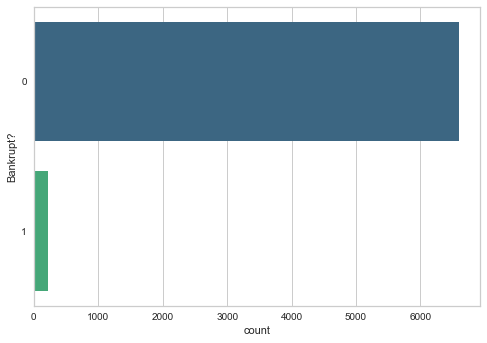

In [78]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h');

# Data Exploration:

In [79]:
ds.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Continuous interest rate (after tax),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,...,Borrowing dependency,Net profit before tax/Paid-in capital,Retained Earnings to Total Assets,Net Income to Total Assets,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.780985,0.147950,0.169141,0.138736,0.629951,0.021266,0.207576,...,0.390284,0.137757,0.903225,0.716845,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.781506,0.182251,0.208944,0.169918,0.635172,0.012502,0.171176,...,0.376760,0.168962,0.931065,0.795297,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.780284,0.177911,0.180581,0.142803,0.629631,0.021248,0.207516,...,0.379093,0.148036,0.909903,0.774670,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.781241,0.154187,0.193722,0.148603,0.630228,0.009572,0.151465,...,0.379743,0.147561,0.906902,0.739555,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.781550,0.167502,0.212537,0.168412,0.636055,0.005150,0.106509,...,0.375025,0.167461,0.913850,0.795016,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [80]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

0

In [81]:
# Checking the type of the columns
ds.dtypes

 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Continuous interest rate (after tax)                       float64
 Net Value Per Share (B)                                    float64
 Persistent EPS in the Last Four Seasons                    float64
 Per Share Net profit before tax (Yuan ¥)                   float64
 Interest Expense Ratio                                     float64
 Total debt/Total net worth                                 float64
 Debt ratio %                                               float64
 Net worth/Assets                                           float64
 Borrowing dependency                                       float64
 Net profit before tax/Paid-in capital                      float64
 Retained Earnings to Total Assets                          float64
 Net Income to Total Assets                     

# Data Pre-processing:

In [82]:
X = ds.copy(deep=True)

## Dealing with outliers:

In [83]:
X.columns

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Continuous interest rate (after tax)', ' Net Value Per Share (B)',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Interest Expense Ratio',
       ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets',
       ' Borrowing dependency', ' Net profit before tax/Paid-in capital',
       ' Retained Earnings to Total Assets', ' Net Income to Total Assets',
       ' Net Income to Stockholder's Equity', ' Liability to Equity',
       ' Degree of Financial Leverage (DFL)',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Equity to Liability', 'Bankrupt?'],
      dtype='object')

In [84]:
# cols = X.drop(columns="Bankrupt?").columns

# X = removeOutliers(X, colList=cols , lowPercentile=0.03, highPercentile=0.97, verbose=True) 

## Splitting the dataset:

In [ ]:
y = X["Bankrupt?"]
X = X.drop(columns=["Bankrupt?"])

In [88]:
# Split the dataset intro train and test sets.

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,
                                   shuffle =True, stratify=y, random_state=SEED)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3,
                                                   shuffle = True, stratify=y_train, random_state=SEED)

In [89]:
y_train.value_counts()

0    3233
1     108
Name: Bankrupt?, dtype: int64

In [90]:
y_val.value_counts()

0    1980
1      66
Name: Bankrupt?, dtype: int64

In [91]:
y_test.value_counts()

0    1386
1      46
Name: Bankrupt?, dtype: int64

In [92]:
#y_train = tf.reshape(y_train, [-1, 1])
#y_test = tf.reshape(y_test, [-1, 1])

In [93]:
#y_train.shape

## Data Normalization:

In [94]:
# We use the standard scaler in order to normalize the data:

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [95]:
# x_train = tf.reshape(x_train, [x_train.shape[0], x_train.shape[1]])
# x_test = tf.reshape(x_test, [x_test.shape[0], x_test.shape[1]])

In [96]:
x_train.shape

(3341, 20)

# Modelling:

## Building The First Model:

In [97]:
# METRICS = [
#     FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'),
#     Precision(name='precision'), Recall(name='recall'), AUC(name='auc'),]

In [98]:
# # Building the first model

# def create_model(nn=16, nl=1, learning_rate=0.001, activation="relu", optim="adam", 
#                  init="glorot_uniform", loss = "binary_crossentropy"):
#     classifier = Sequential()
#     # Let's add the first hidden layers
#     classifier.add(Dense(units=nn, kernel_initializer=init, activation=activation,
#                          input_dim=X_train.shape[1])) 
    
#     for _ in range(nl):
#         classifier.add(Dense(units=8, kernel_initializer=init, activation=activation))
#         classifier.add(Dense(units=1, kernel_initializer=init, activation="sigmoid"))
    
#     classifier.compile(optimizer=optim, loss=loss, metrics=) # need to fill this.
#     return classifier

### Hyper parameters tuning:

#### Using Keras tuner:

- This part is inspired from: https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
- https://keras.io/guides/keras_tuner/getting_started/
- https://keras.io/api/utils/serialization_utils/

In [99]:
# # S.M.O.T.E

# sm = SMOTE(k_neighbors=3, random_state=SEED)
# x_train, y_train = sm.fit_resample(x_train, y_train)

In [100]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [101]:
class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))

In [102]:
y_train.shape

(3341,)

In [103]:
# Defining the Recall, Precision and the F1-score:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [104]:
# defining a call that will clean out output at the end of every training epoch
 
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [105]:
EarlyStop = EarlyStopping(monitor='f1_m', patience=3)
Clear =  ClearTrainingOutput()
Hist = History()

CallBacksList = [EarlyStop, Clear, Hist] # Clear

In [106]:
class FocalLoss(tf.keras.losses.Loss):
    #def __init__(self, gamma, alpha):
    def call(self, gamma, alpha, y_true, y_pred):
        gamma = float(gamma)
        alpha = float(alpha)
        #def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    #return focal_loss_fixed

In [107]:
tfa.losses.SigmoidFocalCrossEntropy()

In [108]:
tf.keras.losses.BinaryCrossentropy()

In [109]:
class MyHyperModel(kt.HyperModel):

    def build(self ,hp):

        hp_units_1 = hp.Choice("Layer 1", [32, 64, 128,])
        hp_units_2 = hp.Choice("Layer 2", [16, 32, 64])
        hp_units_3 = hp.Choice("Layer 3", [4, 8, 16])
        #hp_units_4 = hp.Choice("Layer 4", [4, 8, 16])
        hp_activation = hp.Choice("activation", ["relu", "tanh"])
        hp_learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
                                          
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = "random_normal", #"glorot_uniform",
                        kernel_regularizer = tf.keras.regularizers.L2(0.1),
                        activation = hp_activation,
                        input_dim = x_train.shape[1]   
                           )) 
    
        # Tune whether to use dropout.
#         if hp.Boolean("dropout"):
#             model.add(layers.Dropout(rate=0.5))
    
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = "random_normal",   #"glorot_uniform", 
                            activation = hp_activation))
            
#         if hp.Boolean("dropout"):
#             model.add(layers.Dropout(rate=0.5))
            
        model.add(layers.Dense(units = hp_units_3, 
                            kernel_initializer = "random_normal",   #"glorot_uniform", 
                            activation = hp_activation))
            
#         if hp.Boolean("dropout"):
#             model.add(layers.Dropout(rate=0.5))
            
#         model.add(layers.Dense(units = hp_units_4, 
#                             kernel_initializer = "random_normal",   #"glorot_uniform", 
#                             activation = hp_activation))
            
#         if hp.Boolean("dropout"):
#             model.add(layers.Dropout(rate=0.5))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = "random_normal",  #"glorot_uniform",
                            activation="sigmoid"))
            
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = "binary_crossentropy",
                        metrics= ["accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Recall()
                            , f1_m])
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = focal_loss(alpha=.25, gamma=2),  
                        metrics= ["accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Recall()
                                    , f1_m])
    
        return model

    def fit(self, hp, model, x, y, validation_data=None, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64])
        #hp_epochs = hp.Choice("epochs", [5, 10, 100])
        
#         if hp.Boolean("normalize"):
#             x = layers.Normalization()(x)
        return model.fit(
            x,
            y,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            validation_data=validation_data,
            #epochs = hp_epochs
            batch_size = hp_batch_size,
            class_weight = class_weights,
            **kwargs,
        )

In [110]:
tuner = kt.Hyperband(
    hypermodel = MyHyperModel(),
    objective = kt.Objective("f1_m", direction="max"),
    #objective = 'val_accuracy', # to change
    executions_per_trial=2, 
    overwrite=True,
    directory = 'Deep_learning_project',
    project_name="Default_predictions"
)

In [111]:
tuner.search(x_train, y_train,
             validation_data = (x_val, y_val),
             epochs = 100,
             verbose = 1,
             initial_epoch = 0,
             callbacks = CallBacksList,
             use_multiprocessing = True,
            )

Trial 254 Complete [00h 00m 19s]
f1_m: 0.21701329201459885

Best f1_m So Far: 0.29446467757225037
Total elapsed time: 01h 01m 43s
INFO:tensorflow:Oracle triggered exit


In [143]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get("Layer 1")}, the second layer is {best_hps.get("Layer 2")}, 
the third layer is {best_hps.get("Layer 3")}, the optimal activation function is {best_hps.get("activation")}, 
the best loss function is {best_hps.get("loss_type")}  
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32, the second layer is 16, 
the third layer is 4, the optimal activation function is relu, 
the best loss function is BC  
and the optimal learning rate for the optimizer
is 0.0007550056505506986.



In [144]:
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))

In [145]:
EarlyStop = EarlyStopping(monitor='accuracy', patience=3) # f1_m
Hist = History()

callbacks_list = [EarlyStop, Hist] # Clear

In [146]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=100)
# , callbacks = callbacks_list

val_f1_per_epoch = history.history['val_f1_m']
best_epoch = val_f1_per_epoch.index(max(val_f1_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
105/105 [==============================] - 3s 11ms/step - loss: 0.7360 - accuracy: 0.9590 - auc_3: 0.4994 - recall_3: 0.0093 - f1_m: 5.9524e-04 - val_loss: 0.6702 - val_accuracy: 0.9677 - val_auc_3: 0.5000 - val_recall_3: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/100
105/105 [==============================] - 1s 8ms/step - loss: 0.6451 - accuracy: 0.9677 - auc_3: 0.5349 - recall_3: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.6244 - val_accuracy: 0.9677 - val_auc_3: 0.5000 - val_recall_3: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/100
105/105 [==============================] - 1s 6ms/step - loss: 0.6080 - accuracy: 0.9677 - auc_3: 0.5125 - recall_3: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.5919 - val_accuracy: 0.9677 - val_auc_3: 0.5000 - val_recall_3: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/100
105/105 [==============================] - 1s 5ms/step - loss: 0.5771 - accuracy: 0.9677 - auc_3: 0.4992 - recall_3: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.5623 - val_accura

In [147]:
history.history

{'loss': [0.7360378503799438,
  0.6451238989830017,
  0.6080355048179626,
  0.577138364315033,
  0.5485062599182129,
  0.5217615962028503,
  0.49676084518432617,
  0.4733949303627014,
  0.4515475630760193,
  0.43114909529685974,
  0.412090927362442,
  0.39429929852485657,
  0.3776722252368927,
  0.36217060685157776,
  0.3476681709289551,
  0.3340935707092285,
  0.3214001953601837,
  0.30955177545547485,
  0.298449844121933,
  0.2880786955356598,
  0.278390109539032,
  0.26932039856910706,
  0.2608281672000885,
  0.25287023186683655,
  0.2454085499048233,
  0.23843704164028168,
  0.2319028526544571,
  0.2257663458585739,
  0.22002804279327393,
  0.21464931964874268,
  0.20962409675121307,
  0.20492064952850342,
  0.20051705837249756,
  0.19638453423976898,
  0.19251830875873566,
  0.18890079855918884,
  0.18550963699817657,
  0.18231849372386932,
  0.17933763563632965,
  0.17656315863132477,
  0.17396403849124908,
  0.17152610421180725,
  0.16925504803657532,
  0.16713948547840118,
  0.

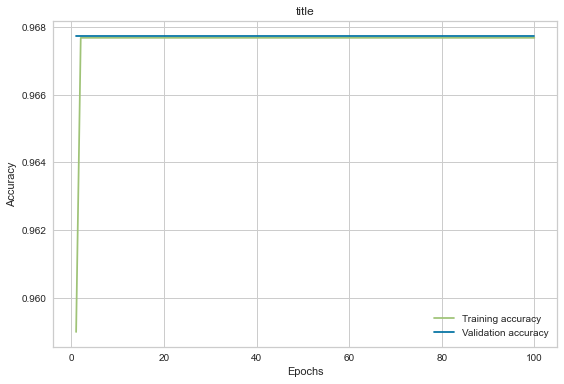

In [148]:
visualize_accuracy(history, "title")

In [149]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_all, y_all, epochs = best_epoch)

169/169 [==============================] - 1s 3ms/step - loss: 0.5734 - accuracy: 0.9655 - auc_4: 0.5403 - recall_4: 0.0000e+00 - f1_m: 0.0000e+00


- https://www.tensorflow.org/tutorials/keras/keras_tuner

In [119]:
# # This function is similar to the one above:

# def build_model(hp, nl=1):
    
#     hp_units = hp.Int('units', min_value = 32, max_value = 256, step = 32)
#     hp_activation = hp.Choice("activation", ["relu", "tanh"])
#     hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
#     classifier = Sequential()
    
#     classifier.add(Dense(units= hp_units,
#                          kernel_initializer="glorot_uniform",
#                          kernel_regularizer = tf.keras.regularizers.L2(0.1),
#                          activation = hp_activation,
#                          input_shape = (X_train.shape[1], )
#                         )) 
    
#     # Tune whether to use dropout.
#     if hp.Boolean("dropout"):
#         classifier.add(layers.Dropout(rate=0.25))
    
#     #for _ in range(nl):
#     classifier.add(Dense(units=16, 
#                          kernel_initializer="glorot_uniform", 
#                          activation = hp_activation))
#     classifier.add(Dense(units=1, 
#                          kernel_initializer="glorot_uniform",
#                          activation="sigmoid"))
            
#     classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
#                 loss='binary_crossentropy',metrics= f1_m)
    
#     return classifier

In [120]:
# X_train.shape[1]

In [121]:
# # Does this use cross validation or not?

# tuner = kt.Hyperband(
#     hypermodel = build_model,
#     objective = kt.Objective("f1_m", direction="max"),
#     max_trials = 3,
#     #max_epochs = 10,
#     max_trials=3,
#     executions_per_trial=2,
#     overwrite=True,
#     overwrite=True,
#     directory = 'Deep_learning_project',
#     project_name="Default_prediction"
# )

In [122]:
# tuner.search_space_summary()

In [123]:
# tuner.results_summary()

In [124]:
# x_all = np.concatenate((x_train, x_val))
# y_all = np.concatenate((y_train, y_val))

In [125]:
# hypermodel = MyHyperModel()
# best_hp = tuner.get_best_hyperparameters()[0]
# model = hypermodel.build(best_hp)
# #hist = hypermodel.fit(best_hp, model, x_all, y_all)

In [150]:
hypermodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                672       
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 4)                 68        
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________


In [127]:
#model.history

In [128]:
# visualize_loss(hist, "Loss function")

In [129]:
# best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [130]:
# best_model.summary()

In [131]:
# I need to resbuild a model here.

In [151]:
y_pred_all = hypermodel.predict(x_all)
y_pred_test = hypermodel.predict(x_test)

In [152]:
y_pred_all = (y_pred_all>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

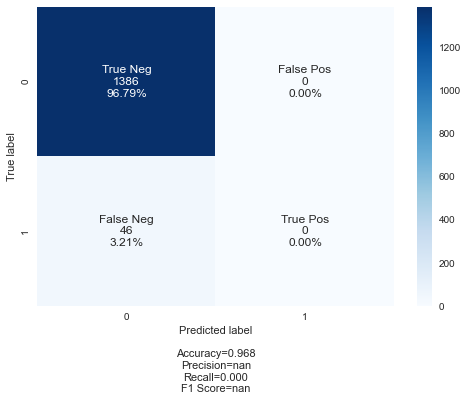

In [153]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [154]:
# Showing the classification report:

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.97      1.00      0.98      1386
     Default       0.00      0.00      0.00        46

    accuracy                           0.97      1432
   macro avg       0.48      0.50      0.49      1432
weighted avg       0.94      0.97      0.95      1432



In [155]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_all, y_pred_all, 
                                 y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.9677,0.967877
1,PRECISION,0.0000,0.000000
2,RECALL,0.0000,0.000000
3,F1 SCORE,0.0000,0.000000
4,AUC,0.5000,0.500000


#### Using Scikit Learn wrapper:

https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

In [137]:
# keras_classifier = KerasClassifier(build_fn=create_model, verbose=1)
# # epochs=50, batch_size=256

In [138]:
# create model
# evaluate using 10-fold cross validation

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
# results = cross_val_score(keras_classifier, X_train, y_train, cv=kfold)
# print(results.mean())
# print(results.std())

In [139]:
# optimizers = ['rmsprop', 'adam']
# init = ['glorot_uniform', 'normal', 'uniform']
# epochs = [50, 100, 150]
# batches = [64, 128, 256]

# param_grid = dict(optim=optimizers, epochs=epochs, batch_size=batches, init=init)

# random_search = RandomizedSearchCV(estimator=keras_classifier, param_distributions=param_grid)

# random_search_results = grid.fit(X_train, y_train)


# # summarize results
# print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))

In [140]:
# means = random_search_results.cv_results_['mean_test_score']
# stds = random_search_results.cv_results_['std_test_score']
# params = random_search_results.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

#### Building the model:

In [141]:
# Now that we have the best hyper parameters we can build the model:

# classifier = create_model(nn=16, here i should include all the found parameters)

In [142]:
classifier.summary()

NameError: name 'classifier' is not defined

In [ ]:
# Path + name of the file we wanna create.
path_checkpoint = "First_model.h5"

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto") # I don't know if i should use this.

model_save = ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, 
                             save_best_only=True)

Hist_first = History()

In [ ]:
hist = classifier.fit(X_train, y_train,  
                      batch_size=64,
                      validation_split=0.2,
                      # the number of epochs can be high, early stopping will stop training when the val_loss is not improving
                      epochs=1000, 
                      callbacks = [early_stopping, model_save, Hist_first])

In [ ]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
# Converting the predictions to the right format:

y_pred_train=(y_pred_train>0.5).astype(int)
y_pred_test=(y_pred_test>0.5).astype(int)

In [ ]:
# Showing the confusion matrix
cm = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, 
                                 y_test, y_pred_test)
resultsDF

In [ ]:
# Visualizing the train and validation loss:

visualize_loss(hist, "Training and validation loss")

In [ ]:
# Visualizing the train and validation accuracy:

visualize_accuracy(hist, "Training and validation accuracy")

In [ ]:
# Maybe i can also add other plots.

## Using class_weight:

In [ ]:
# Getting the weights of each class

class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))

In [ ]:
# Now that we have the best hyper parameters we can build the model:

# classifier = create_model(nn=16, here i should include all the found parameters)

In [ ]:
# Path + name of the file we wanna create.
path_checkpoint = "Second_model.h5"

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto")

model_save = ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, 
                             save_best_only=True)

Hist_second = History()

In [ ]:
# I SHOULD PAY ATTENTION TO THE MODEL NAME.

hist = classifier.fit(X_train, y_train,  
                      batch_size=64,
                      validation_split=0.2,
                      epochs=1000,
                      callbacks = [early_stopping, model_save, Hist_second],  
                      class_weight=class_weights
                     )

In [ ]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
# Converting the predictions to the right format:

y_pred_train=(y_pred_train>0.5).astype(int)
y_pred_test=(y_pred_test>0.5).astype(int)

In [ ]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, 
                                 y_test, y_pred_test)
resultsDF

In [ ]:
# Visualizing the train and validation loss:

visualize_loss(hist, "Training and validation loss")

In [ ]:
# Visualizing the train and validation accuracy:

visualize_accuracy(hist, "Training and validation accuracy")

## Using a Focal Loss:

https://github.com/umbertogriffo/focal-loss-keras
- I should add few comments about the focal loss function, and why we choose to use it.
- "focal loss down-weights the well-classified examples. This has the net effect of putting more training emphasis on that data that is hard to classify. In a practical setting where we have a data imbalance, our majority class will quickly become well-classified since we have much more data for it. Thus, in order to insure that we also achieve high accuracy on our minority class, we can use the focal loss to give those minority class examples more relative weight during training."

In [ ]:
# MAKE SURE YOU CHOOSE THE RIGHT PARAMETERS, I NEED TO CHECK THAT OLD FILE AND SEE IF ITS THE SAME OR NOT.

create_model(loss = focal_loss(gamma=1.5,alpha=0.25))

In [ ]:
# Path + name of the file we wanna create.
path_checkpoint = "Third_model.h5"

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto")

model_save = ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, 
                             save_best_only=True)

Hist_third = History()

In [ ]:
# I SHOULD PAY ATTENTION TO THE MODEL NAME.

hist = classifier.fit(X_train, y_train,  
                      batch_size=64,
                      validation_split=0.2,
                      epochs=1000,
                      callbacks = [early_stopping, model_save, Hist_third], 
                     )

In [ ]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
# Converting the predictions to the right format:

y_pred_train=(y_pred_train>0.5).astype(int)
y_pred_test=(y_pred_test>0.5).astype(int)

In [ ]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, 
                                 y_test, y_pred_test)
resultsDF

In [ ]:
# Visualizing the train and validation loss:

visualize_loss(hist, "Training and validation loss")

In [ ]:
# Visualizing the train and validation accuracy:

visualize_accuracy(hist, "Training and validation accuracy")

## Using S.M.O.T.E:

- Should insert a small introduction about what S.M.O.T.E is.

In [ ]:
# S.M.O.T.E

sm = SMOTE(k_neighbors=10, random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# MAKE SURE YOU CHOOSE THE RIGHT PARAMETERS, I NEED TO CHECK THAT OLD FILE AND SEE IF ITS THE SAME OR NOT.

# create_model()

In [ ]:
# Path + name of the file we wanna create.
path_checkpoint = "Fourth_model.h5"

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto")

model_save = ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, 
                             save_best_only=True)

Hist_fourth = History()

In [ ]:
# I SHOULD PAY ATTENTION TO THE MODEL NAME.

hist = classifier.fit(X_train, y_train,  
                      batch_size=64,
                      validation_split=0.2,
                      epochs=1000,
                      callbacks = [early_stopping, model_save, Hist_third], 
                     )

In [ ]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
# Converting the predictions to the right format:

y_pred_train=(y_pred_train>0.5).astype(int)
y_pred_test=(y_pred_test>0.5).astype(int)

In [ ]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, 
                                 y_test, y_pred_test)
resultsDF

In [ ]:
# Visualizing the train and validation loss:

visualize_loss(hist, "Training and validation loss")

In [ ]:
# Visualizing the train and validation accuracy:

visualize_accuracy(hist, "Training and validation accuracy")

## Results discussion:

- Insert results discussion here:

In [ ]:
t2 = time.perf_counter()
print('time taken to run:',(t2-t1)/60.0)